## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import DPVerification as dp
import Aggregation as agg

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  0.0 

DP Predicate Test: False 



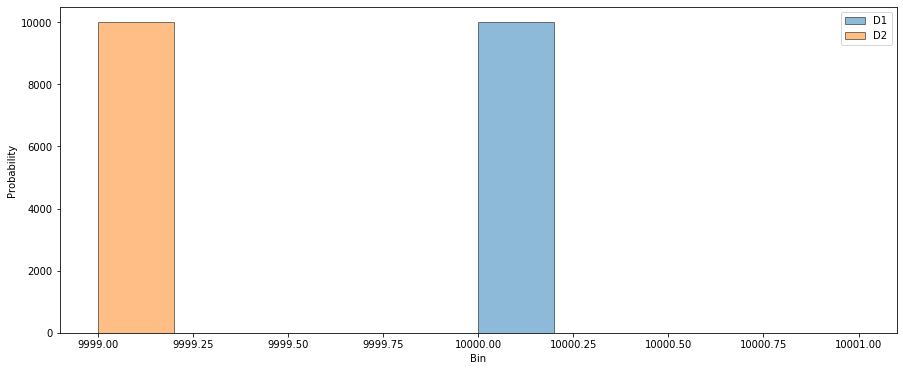

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.967394600022  Stdev fD1:  2.9038229236537214  Mean fD2:  10003.979349547073  Stdev fD2:  2.901616465809466

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1072, pvalue=1.9910433863701831e-50) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  5.034482758620689 

DP Predicate Test: False 



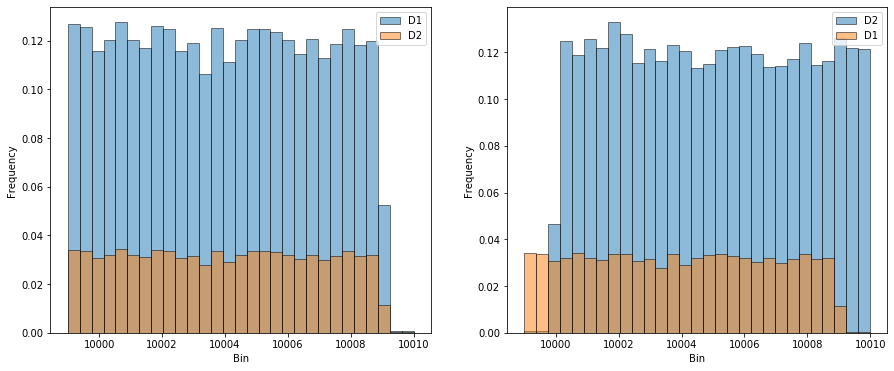

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.871385730805  Stdev fD1:  5.368257295621045  Mean fD2:  9998.97123189085  Stdev fD2:  5.387870582753535

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0638, pvalue=4.0945587758030704e-18) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  3.5681818181818192 

DP Predicate Test: True 



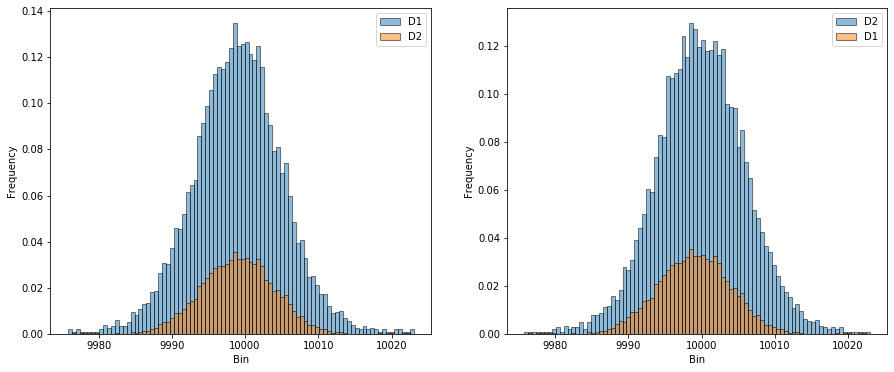

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  19876.949562811995  Stdev fD1:  63.776429519417434  Mean fD2:  19875.616764257546  Stdev fD2:  64.04152171207586

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0146, pvalue=0.2369059200442076) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  6.756097560975609 

DP Predicate Test: True 



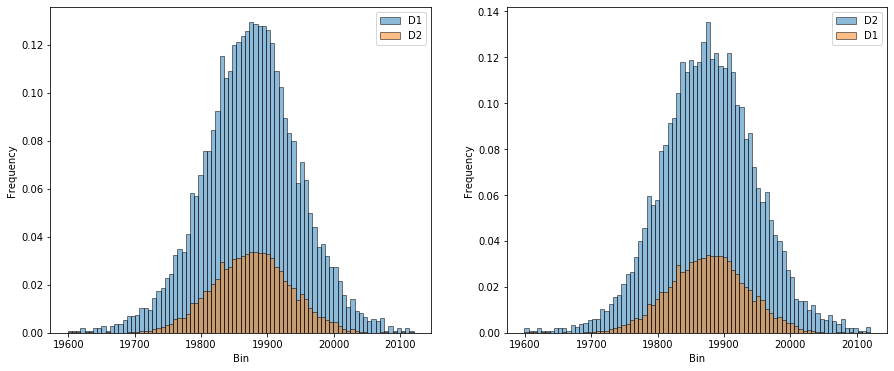

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  1.9876735133710504  Stdev fD1:  0.006452983347738146  Mean fD2:  1.9877543708924357  Stdev fD2:  0.0065395613019355375

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0119, pvalue=0.4784083389368079) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  4.425000000000001 

DP Predicate Test: True 



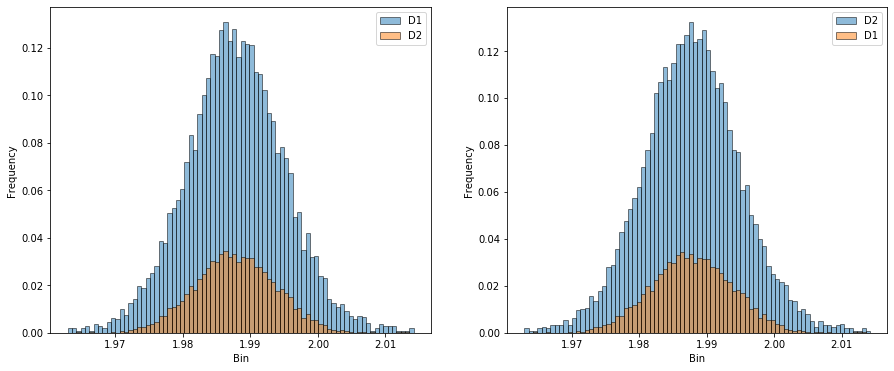

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  1.9214863441107908  Stdev fD1:  0.09351969187972314  Mean fD2:  1.9207301039248574  Stdev fD2:  0.09290377895922441

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0161, pvalue=0.14966522632015317) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  3.9999999999999982 

DP Predicate Test: True 



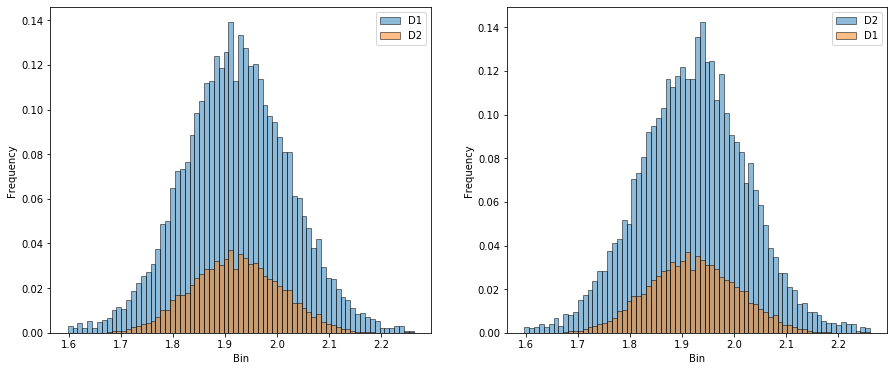

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.066658725324  Stdev fD1:  5.302403755821169  Mean fD2:  9998.910497724642  Stdev fD2:  5.393025835237107

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0942, pvalue=5.105500188303281e-39) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  5.064935064935066 

DP Predicate Test: True 



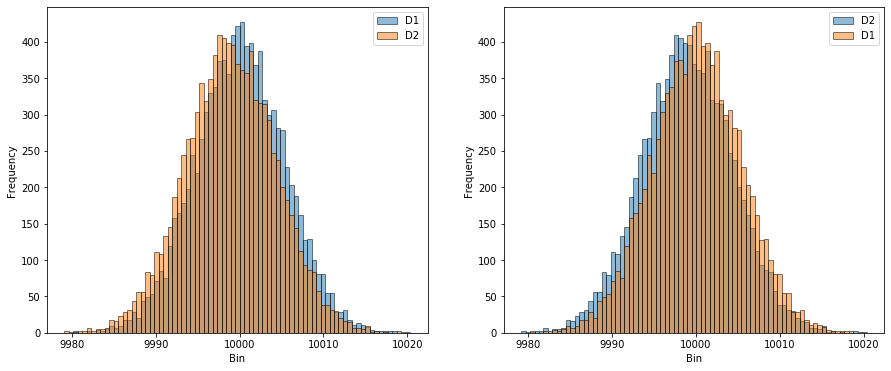

(True,
 Ks_2sampResult(statistic=0.0942, pvalue=5.105500188303281e-39),
 5.064935064935066)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

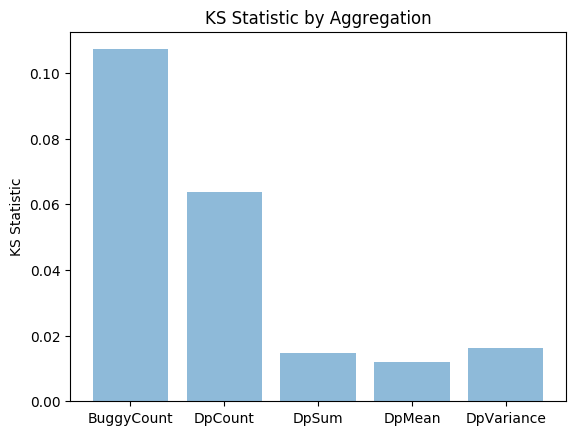

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

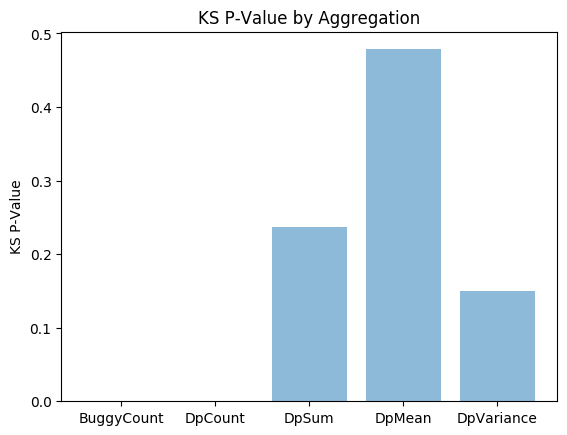

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

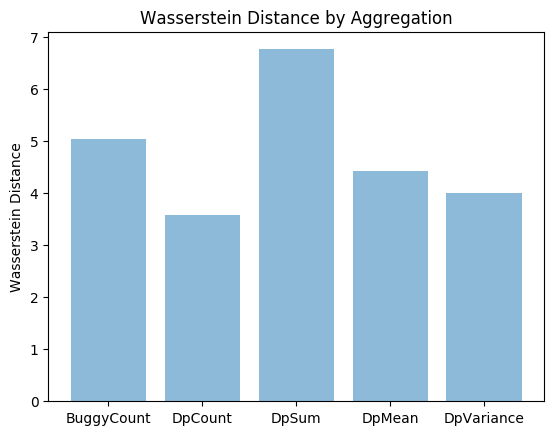

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.019953505132  Stdev fD1:  5.305249710261123  Mean fD2:  9998.958132351274  Stdev fD2:  5.337535320484232

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.083, pvalue=2.2363393366418407e-30) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  5.921052631578947 

DP Predicate Test: True 

--- 0.044515371322631836 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  19878.048222427828  Stdev fD1:  63.79398104871362  Mean fD2:  19875.20084390794  Stdev fD2:  65.05318477182048

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0235, pvalue=0.007989835535840706) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  4.499999999999997 

DP Predicate Test: True 

--- 0.04959583282470703 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.999557665647  Stdev fD1:  2.896014025157355  Mean fD2:  10004.02448858249  Stdev fD2:  2.893013668230772

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1039, pvalue=2.1660433180985196e-47) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance:  5.310344827586206 

DP Predicate Test: False 

--- 0.0491483211517334 seconds ---


### Verifying Burdock Private Query implementation for a sample query

#### Note: Burdock uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM Accuracy and DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


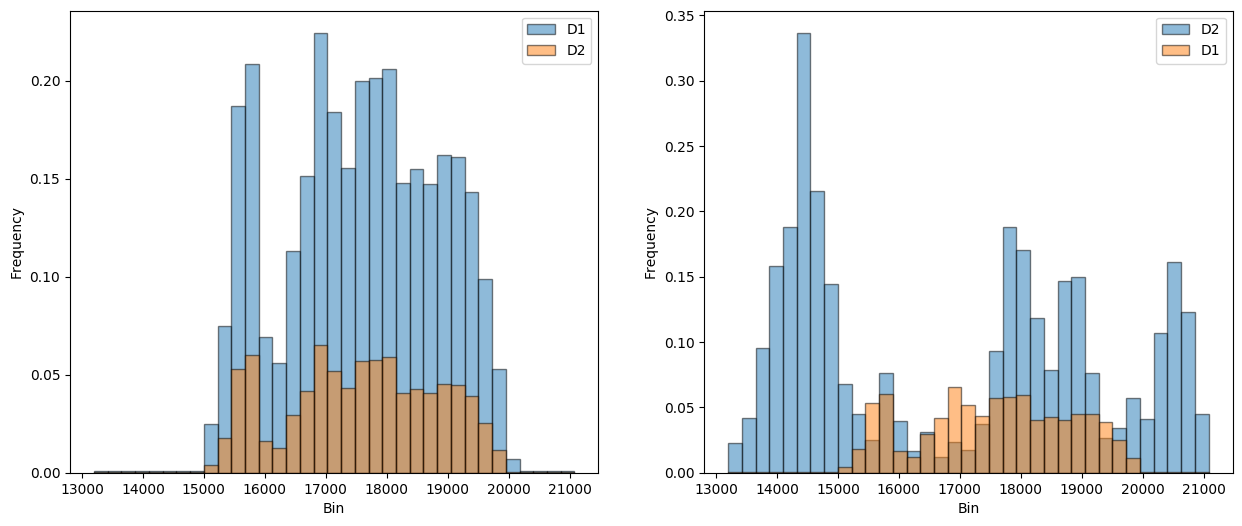

DP Predicate Test:  False
Accuracy Test:  None
--- 21.488512992858887 seconds ---


In [17]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("--- %s seconds ---" % (time.time() - start_time))

### COUNT Accuracy and DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


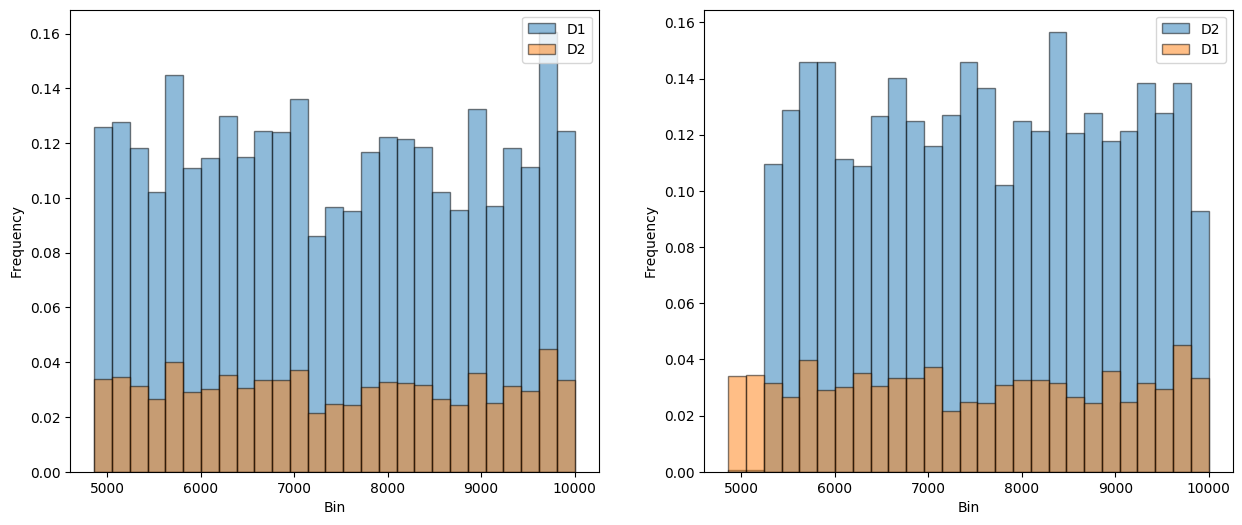

DP Predicate Test:  False
Accuracy Test:  None
--- 19.939247846603394 seconds ---


In [18]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN Test

Length of D1:  10000  Length of D2:  9999
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


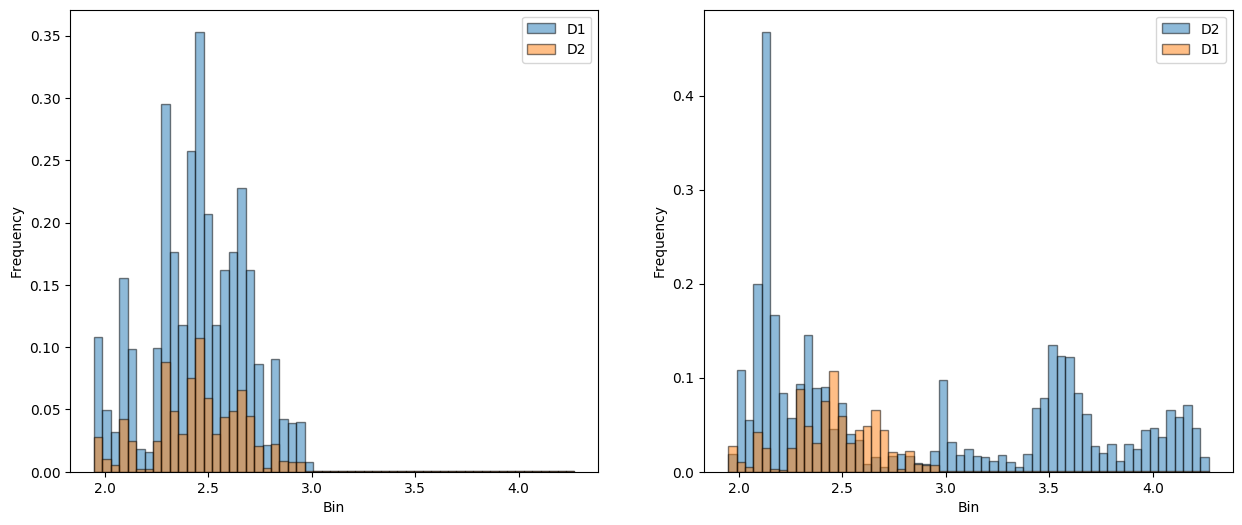

DP Predicate Test:  False
--- 36.25386691093445 seconds ---


In [19]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

### VARIANCE Test

Length of D1:  10000  Length of D2:  9999
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


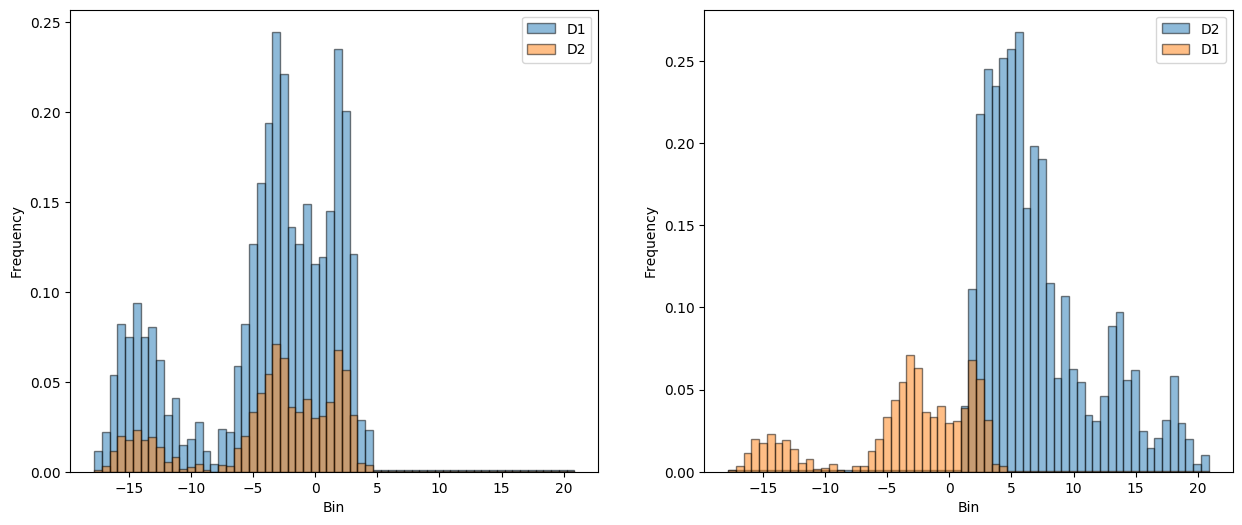

DP Predicate Test:  False
--- 40.724318981170654 seconds ---


In [20]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT VAR(Usage) AS UsageVar FROM d1.d1"
d2_query = "SELECT VAR(Usage) AS UsageVar FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Loaded 3 records
Testing:  012_0
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


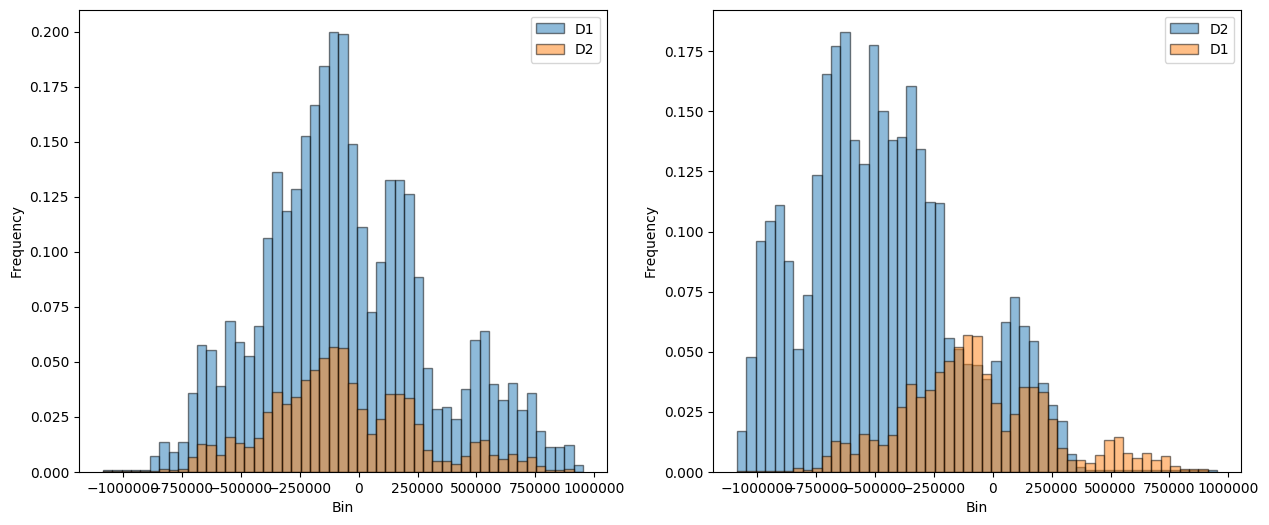

012_0 False None
Testing:  12_1
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


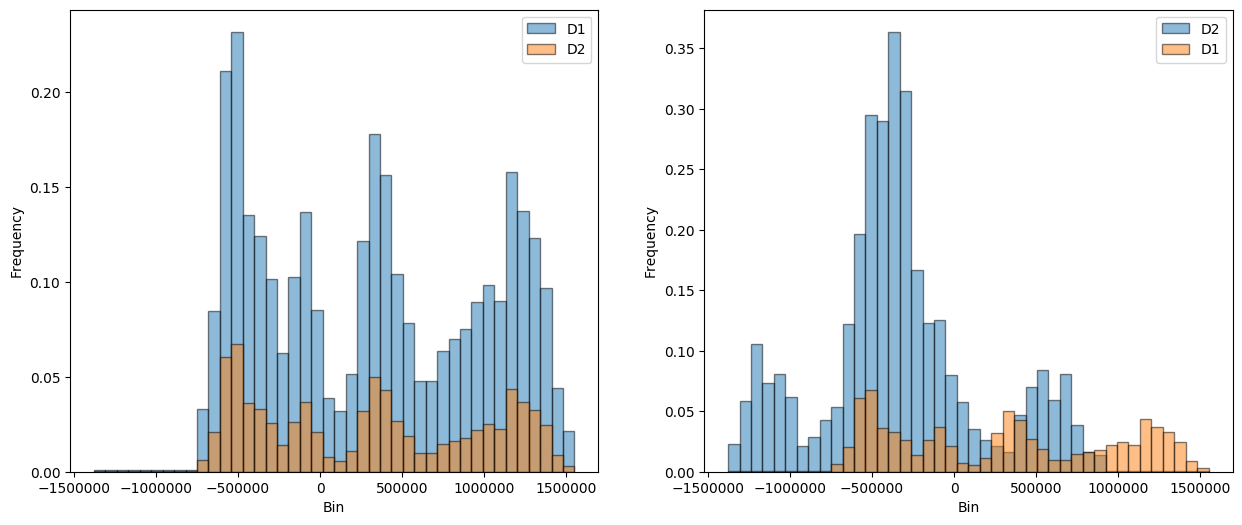

12_1 False None
Testing:  2_2
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


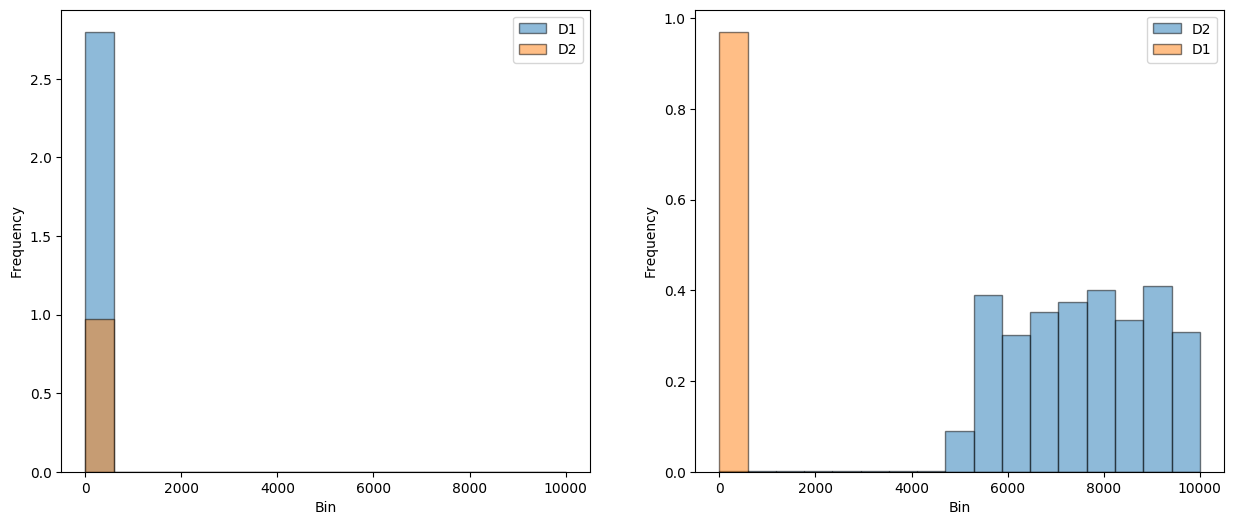

2_2 False None
Testing:  12_2
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


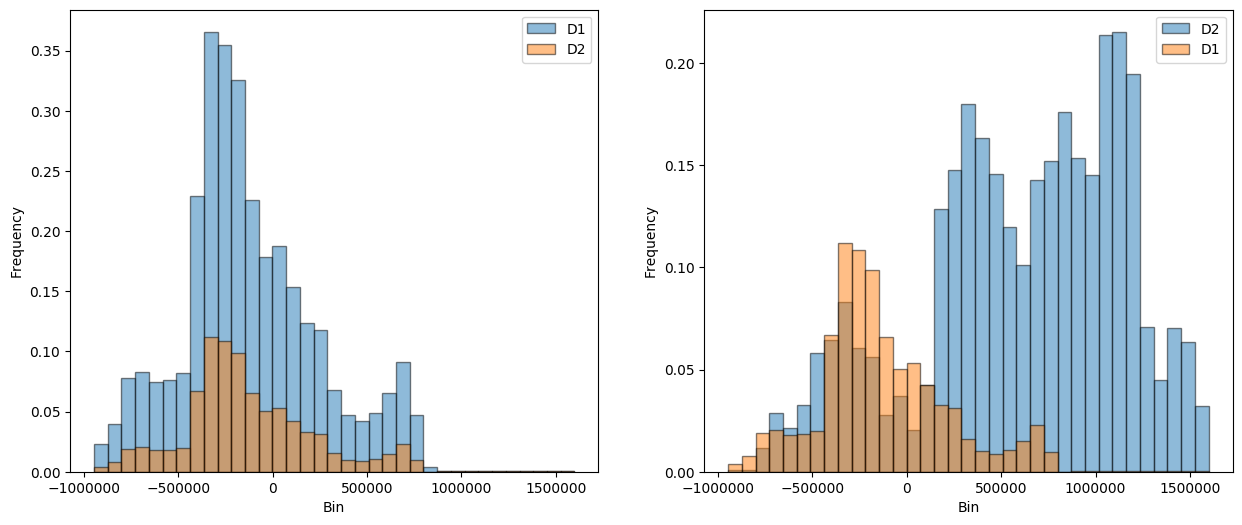

12_2 False None
Testing:  1_1
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


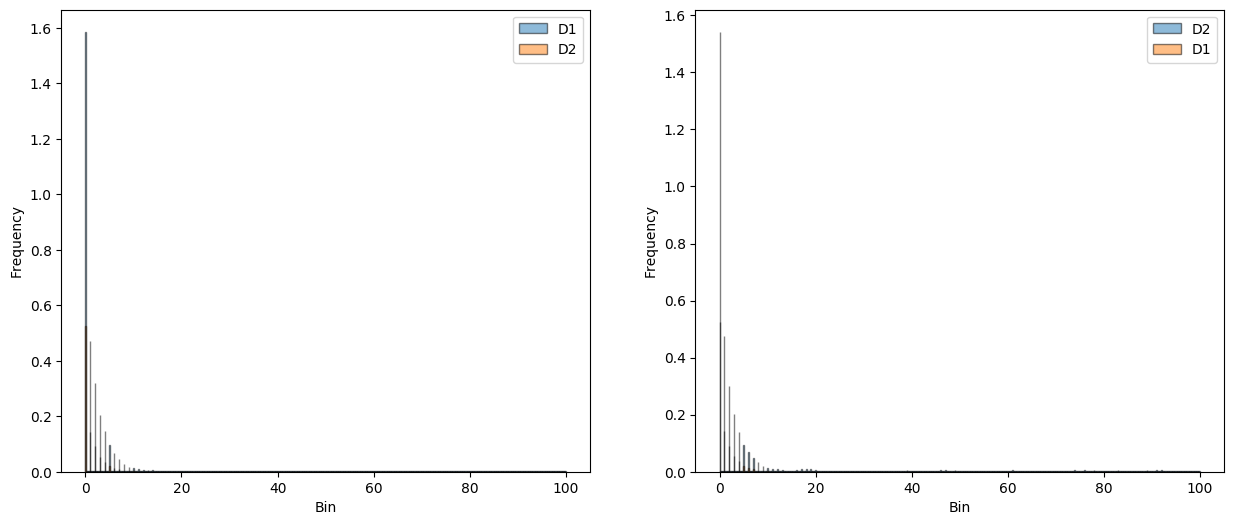

1_1 True None
Testing:  012_1
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


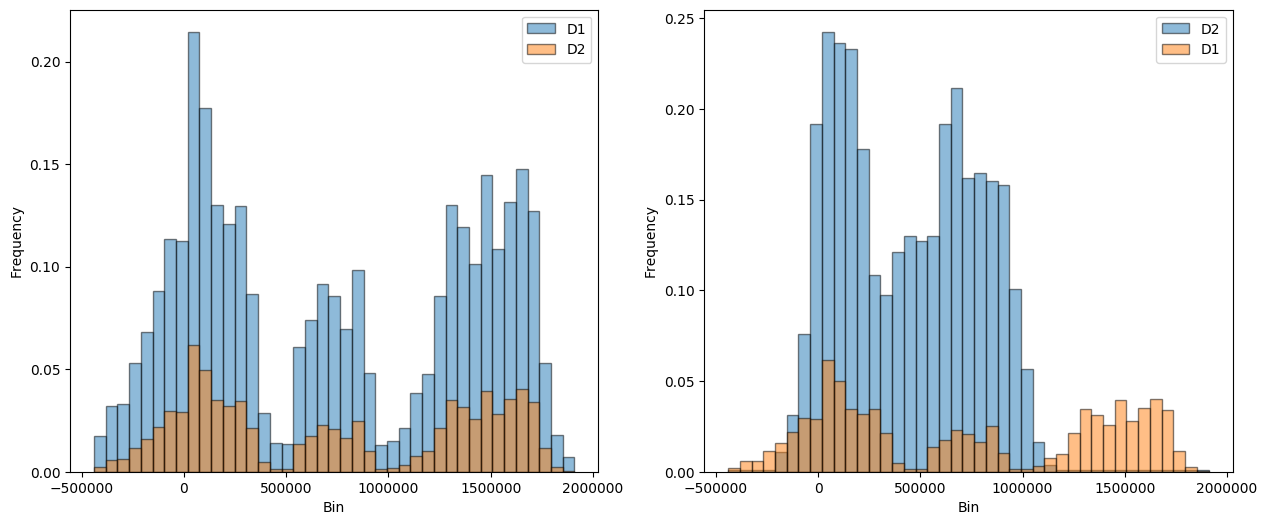

012_1 False None
Testing:  02_0
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


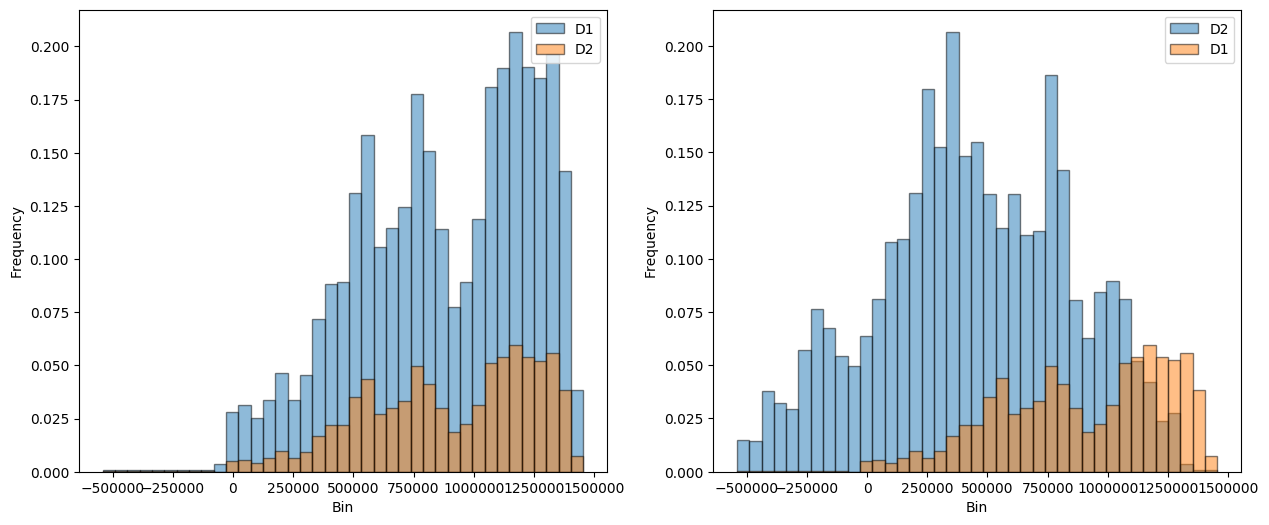

02_0 False None
Testing:  02_2
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


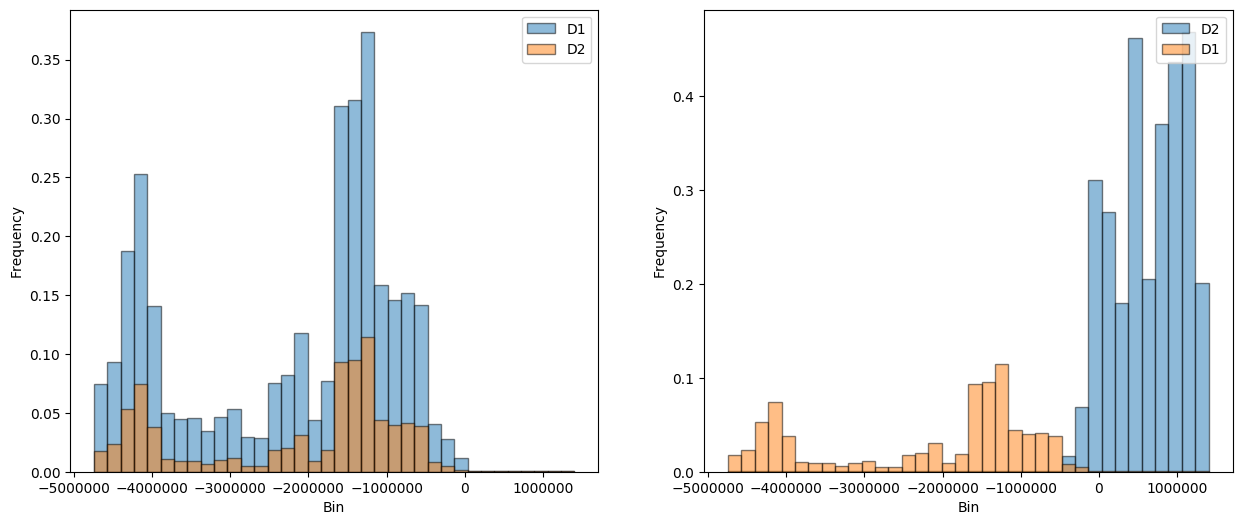

02_2 False None
Testing:  0_0
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


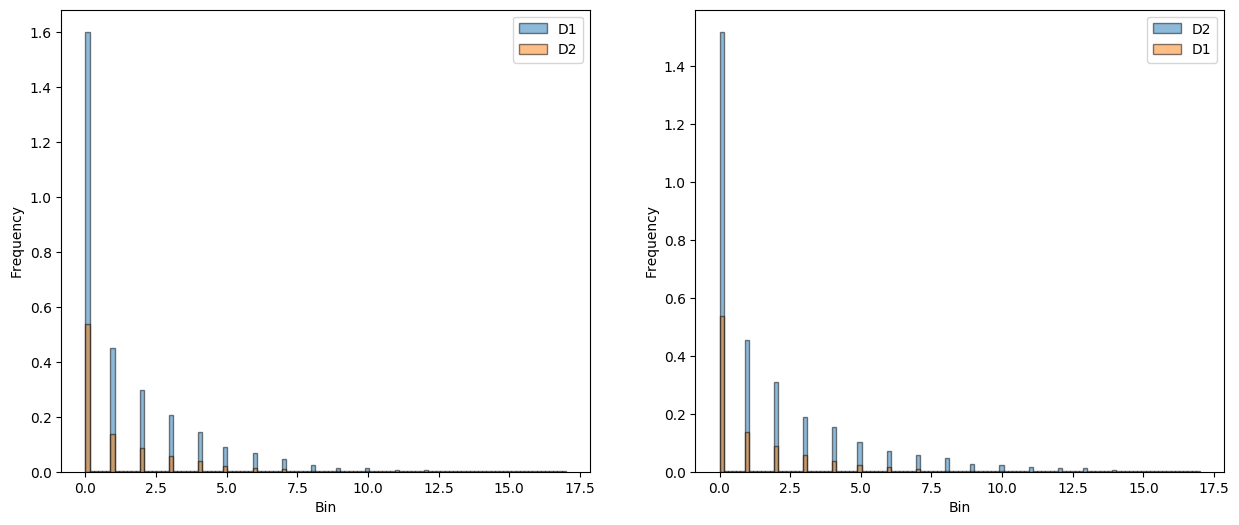

0_0 True None
Testing:  012_2
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


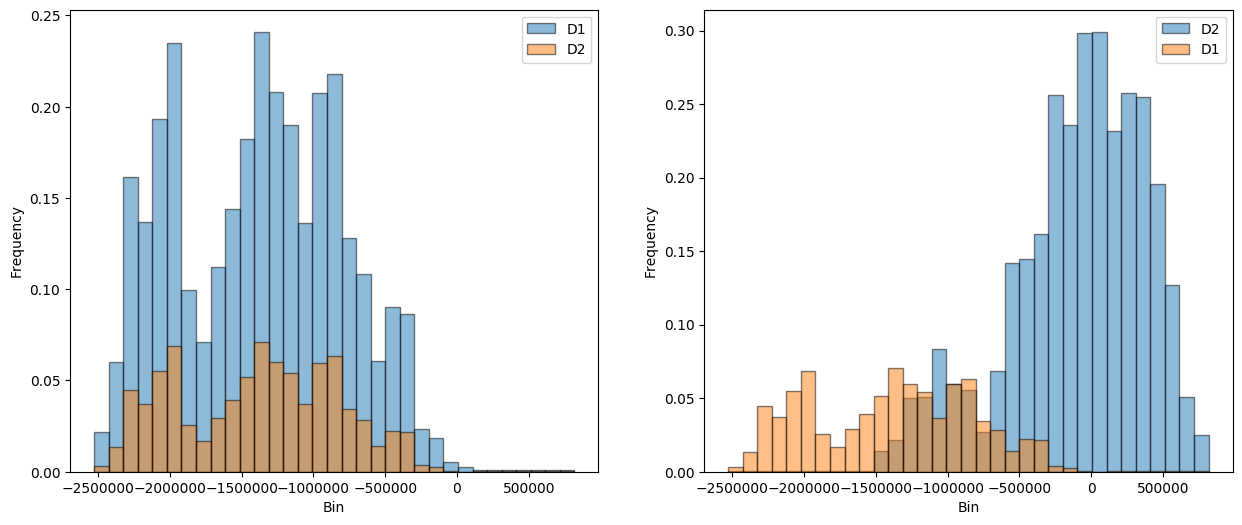

012_2 False None
Testing:  01_0
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


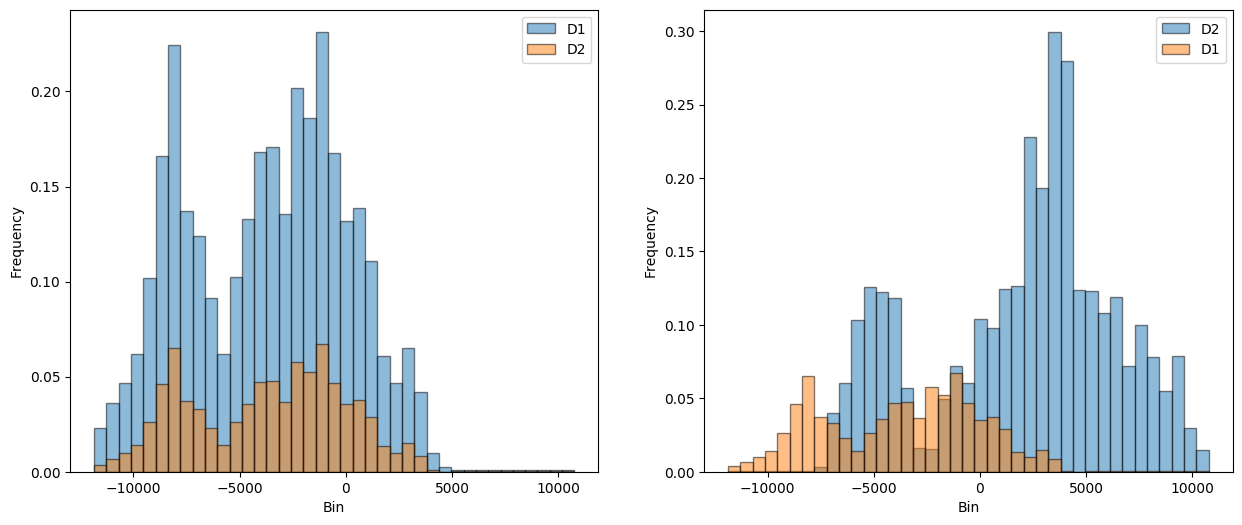

01_0 False None
Testing:  01_1
Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000


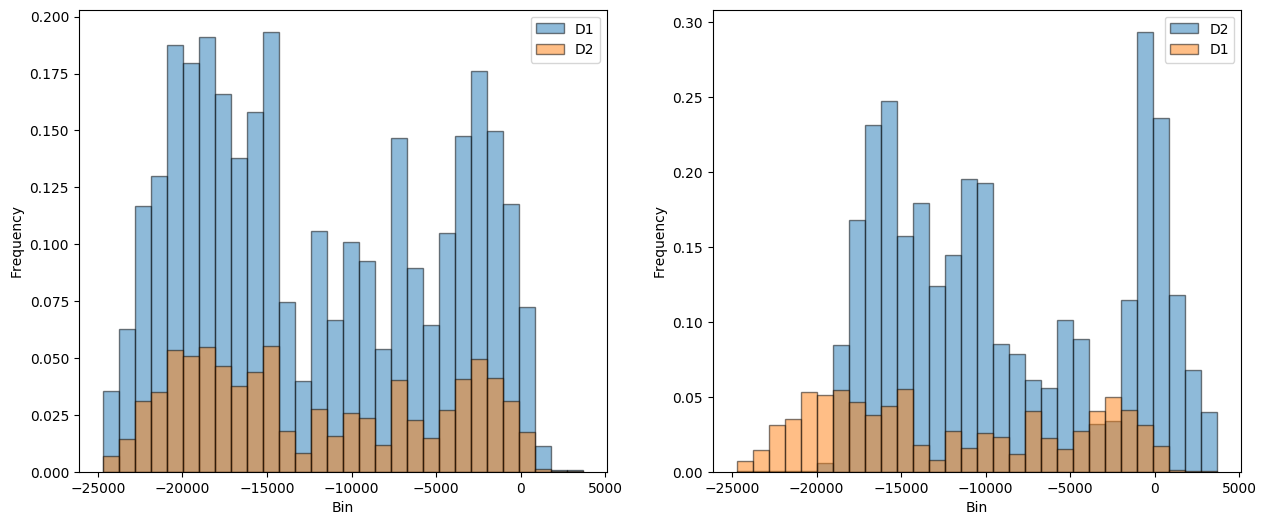

01_1 False None
DP Powerset Test:  {'012_0': [False, None], '12_1': [False, None], '2_2': [False, None], '12_2': [False, None], '1_1': [True, None], '012_1': [False, None], '02_0': [False, None], '02_2': [False, None], '0_0': [True, None], '012_2': [False, None], '01_0': [False, None], '01_1': [False, None]}
--- 285.267733335495 seconds ---


In [25]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
res_list = dv.dp_powerset_test(query_str, plot=True)
print("DP Powerset Test: ", res_list)
print("--- %s seconds ---" % (time.time() - start_time))